In [40]:
import tensorflow as tf
from tensorflow import keras

In [41]:
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train,y_train),(x_test,y_test) =  mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.reshape(-1,28,28,1).astype('float32')/255.0
x_test = x_test.reshape(-1,28,28,1).astype('float32')/255.0

In [ ]:
class CNNBlock(layers.Layer):
  def __init__(self, out_channels,kernel_size=3,padding='same'):
    super().__init__()
    self.conv = layers.Conv2D(out_channels,kernel_size,padding=padding)
    self.batch_norm = layers.BatchNormalization()

  def call(self,input_tensor,training=False):
    x = self.conv(input_tensor)
    x = self.batch_norm(x)
    x = tf.nn.relu(x)
    return x


class ResBlock(layers.Layer):
  def __init__(self,channels):
    super().__init__()
    self.block1 = CNNBlock(channels[0])
    self.block2 = CNNBlock(channels[1])
    self.block3 = CNNBlock(channels[2])
    self.pooling = layers.MaxPooling2D()
    self.identity_mapping = layers.Conv2D(channels[1],kernel_size=(1,1),padding='same')

  def call(self, input_tensor,training=False):
    x = self.block1(input_tensor,training=training)
    x = self.block2(x, training=training)
    x = self.block3(x + self.identity_mapping(input_tensor), training=training)
    return self.pooling(x)
  

class ResNetLike(keras.Model):
  def __init__(self,num_classes=10):
    super().__init__()  
    self.conv1 = ResBlock([32,32,64])
    self.conv2 = ResBlock([128,128,256])
    self.conv3 = ResBlock([128,256,512])
    self.pool = layers.GlobalAveragePooling2D()
    self.classifier = layers.Dense(num_classes)

  def call(self, input_tensor,training=False):
    x = self.conv1(input_tensor, training=training)
    x = self.conv2(x, training=training)
    x = self.conv3(x, training=training)
    x = self.pool(x)
    return self.classifier(x)

# here we created custom components that we can reuse in a model 
# above we have a template that can be reused in a Convolutional neural network...
# ...consisting of convolutional layers, batch normalization(to speed up training)

In [ ]:
model = ResNetLike(num_classes=10)
model.compile(
    optimizer='adam',
    metrics = ['accuracy'],
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

model.fit(x_train,y_train,epochs=10,batch_size=64)

Epoch 1/10
938/938 [==============================] - 25s 24ms/step - loss: 0.0834 - accuracy: 0.9749
Epoch 2/10
938/938 [==============================] - 22s 24ms/step - loss: 0.0360 - accuracy: 0.9886
Epoch 3/10
938/938 [==============================] - 23s 24ms/step - loss: 0.0282 - accuracy: 0.9913
Epoch 4/10
938/938 [==============================] - 23s 24ms/step - loss: 0.0232 - accuracy: 0.9930
Epoch 5/10
938/938 [==============================] - 23s 25ms/step - loss: 0.0218 - accuracy: 0.9930
Epoch 6/10
938/938 [==============================] - 23s 25ms/step - loss: 0.0169 - accuracy: 0.9946
Epoch 7/10
938/938 [==============================] - 24s 25ms/step - loss: 0.0159 - accuracy: 0.9948
Epoch 8/10
938/938 [==============================] - 24s 25ms/step - loss: 0.0136 - accuracy: 0.9958
Epoch 9/10
938/938 [==============================] - 23s 25ms/step - loss: 0.0128 - accuracy: 0.9958
Epoch 10/10
938/938 [==============================] - 23s 25ms/step - loss: 0.012

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 3s 7ms/step - loss: 0.0303 - accuracy: 0.9903


[0.030295638367533684, 0.9902999997138977]

In [45]:
model.summary()

Model: "res_net_like_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_block_30 (ResBlock)     multiple                  28640     
                                                                 
 res_block_31 (ResBlock)     multiple                  526976    
                                                                 
 res_block_32 (ResBlock)     multiple                  1839744   
                                                                 
 global_average_pooling2d_10  multiple                 0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            multiple                  5130      
                                                                 
Total params: 2,400,490
Trainable params: 2,397,418
Non-trainable params: 3,072
_____________________________________

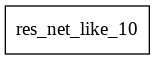

In [46]:
tf.keras.utils.plot_model(model, to_file='model.png',show_shapes=True,show_layer_names=True)